# <font size=8 color=steelblue >**Phase 3: Problem Statement — RetailSmart Advanced Analytics: Unleashing the Power of Data!**
------------------
-----------------

# <font size=5 color=lightseagreen >Business Context
---

RetailSmart is an omni-channel e-commerce company that has already built strong capabilities in data cleaning, exploratory analysis, and churn prediction.
While the predictive model (from Phase 2) helps the company identify which customers are likely to churn, senior management now wants to deepen analytical intelligence in three critical areas:  

- **Customer Segmentation** — to personalize campaigns and retention offers
- **Demand Forecasting** — to plan production, procurement, and logistics
- **Cross-Sell Recommendations** — to increase average order value through bundled sales

The goal of this phase is to use unsupervised learning, time-series analysis, and association rule mining to discover patterns and trends that cannot be easily captured through supervised modeling.

## <font color=skyblue>1: Loading and Prepping the Data – Get Your Ducks in a Row

----------------

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from statsmodels.tsa.arima.model import ARIMA
from mlxtend.frequent_patterns import apriori, association_rules
import warnings
warnings.filterwarnings('ignore')  # Shhh, ignore those pesky warnings

# Set up plotting style for pretty visuals
sns.set_style("darkgrid")
plt.style.use("seaborn-v0_8")

In [2]:
# Load cleaned data
customers = pd.read_csv('/content/customers_cleaned.csv')
sales = pd.read_csv('/content/sales_cleaned.csv')
marketing = pd.read_csv('/content/marketing_cleaned.csv')
products = pd.read_csv('/content/products_cleaned.csv')

In [3]:
# Quick peek at shapes to confirm we're good
print(f"Customers: {customers.shape} rows")
print(f"Products: {products.shape} rows")
print(f"Sales: {sales.shape} rows")
print(f"Marketing: {marketing.shape} rows")

Customers: (99441, 10) rows
Products: (32951, 5) rows
Sales: (106549, 14) rows
Marketing: (500, 8) rows


In [4]:
# Convert dates to datetime for time-series fun
sales['order_purchase_timestamp'] = pd.to_datetime(sales['order_purchase_timestamp'], errors='coerce')
marketing['start_date'] = pd.to_datetime(marketing['start_date'], errors='coerce')

In [5]:
# Drop any NaNs in key columns for clean data
customers.dropna(inplace=True)
sales.dropna(subset=['order_purchase_timestamp'], inplace=True)

## <font color=skyblue >2. Customer Segmentation (Unsupervised Learning)

---

**customer segmentation** is all about unsupervised learning. We're using K-Means clustering on RFM-like features (Recency, Frequency, Monetary) plus marketing stuff like response rate. Goal: Find groups like "High-Value Loyalists" or "At-Risk Shoppers." We'll visualize with PCA and save a summary.

## Key Features:

- **Recency**: Days since last order (from customers).
- **Frequency**: Total orders.
- **Monetary**: Total spent.
- **Avg Spend**: Total spent / orders.
- **Response Rate**: From marketing (merged by customer_id).

- **Group customers into meaningful segments using behavioral and marketing features
(e.g., Recency, Frequency, Monetary, Avg Spend, Response Rate).**

------

In [6]:
# Merge customers with marketing for response rate
cust_mark = pd.merge(customers, marketing[['customer_id', 'response_rate']], on='customer_id', how='left')
cust_mark['response_rate'].fillna(0, inplace=True)  # Fill missing with 0 – no response, no prob

In [7]:
# Create RFM features
features = cust_mark[['total_orders', 'total_spent', 'days_since_last_order', 'response_rate']]
features['avg_spend'] = features['total_spent'] / (features['total_orders'] + 1e-5)  # Avoid divide by zero
features = features[['total_orders', 'total_spent', 'days_since_last_order', 'avg_spend', 'response_rate']]

In [8]:
# Add avg_spend back to cust_mark for later use
cust_mark['avg_spend'] = features['avg_spend']

In [9]:
# Scale the data – K-Means loves normalized stuff
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [10]:
# Find optimal clusters with Elbow Method (plot inertia)
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

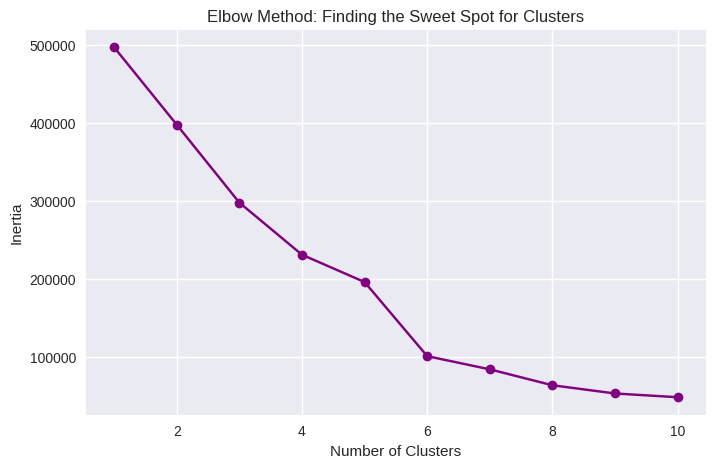

In [11]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o', color='purple')
plt.title('Elbow Method: Finding the Sweet Spot for Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

- **Identify cluster profiles such as High-Value Loyalists, Price-Sensitive Frequent Buyers,
or At-Risk Customers.**

---------

- **Visualize segment separation using PCA and summarize behavioral differences
between clusters.**

---

In [12]:
# Let's go with 4 clusters – based on elbow (you can tweak)
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(scaled_features)
cust_mark['cluster'] = clusters

In [13]:
# PCA for 2D viz – reduce dims to see separation
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)
cust_mark['pca1'] = pca_features[:, 0]
cust_mark['pca2'] = pca_features[:, 1]

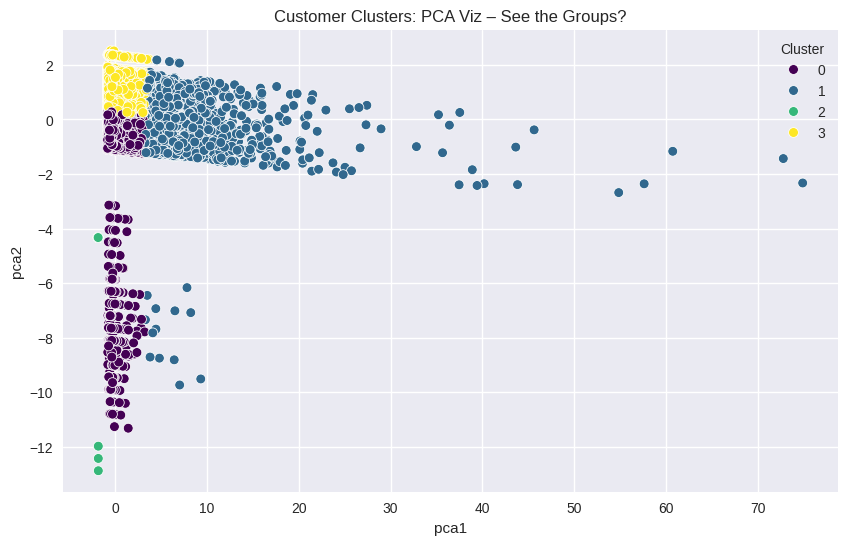

In [14]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=cust_mark, x='pca1', y='pca2', hue='cluster', palette='viridis', s=50)
plt.title('Customer Clusters: PCA Viz – See the Groups?')
plt.legend(title='Cluster')
plt.show()

- **Generate and save a summary of customer clusters as
data_outputs/cluster_summary.csv.**

---

In [15]:
# Summarize clusters – mean values per group
cluster_summary = cust_mark.groupby('cluster')[['total_orders', 'total_spent', 'days_since_last_order', 'avg_spend', 'response_rate']].mean()
cluster_summary['count'] = cust_mark.groupby('cluster')['customer_id'].count()
print(cluster_summary)

         total_orders  total_spent  days_since_last_order    avg_spend  \
cluster                                                                  
0                 1.0   139.744629              153.46681   139.743231   
1                 1.0  1346.462049              241.65167  1346.448585   
2                 0.0     0.000000              224.00000     0.000000   
3                 1.0   141.888992              415.63807   141.887573   

         response_rate  count  
cluster                        
0             0.002506  63981  
1             0.002111   2245  
2             0.001394    775  
3             0.000000  32440  


In [16]:
# Save it!
import os
os.makedirs('data_outputs', exist_ok=True)  # Creating folder

cluster_summary.to_csv('data_outputs/cluster_summary.csv',index=False)
print("Cluster summary saved! ")

Cluster summary saved! 


## <font color=skyblue >3. Demand Forecasting (Time Series Analysis)

---

- **Analyze historical order and revenue trends.**

----

In [17]:
# Aggregate sales by month for orders and revenue
sales['month_year'] = sales['order_purchase_timestamp'].dt.to_period('M')
monthly_orders = sales.groupby('month_year')['order_id'].count().reset_index()
monthly_orders.columns = ['month', 'orders']
monthly_revenue = sales.groupby('month_year')['total_price'].sum().reset_index()
monthly_revenue.columns = ['month', 'revenue']

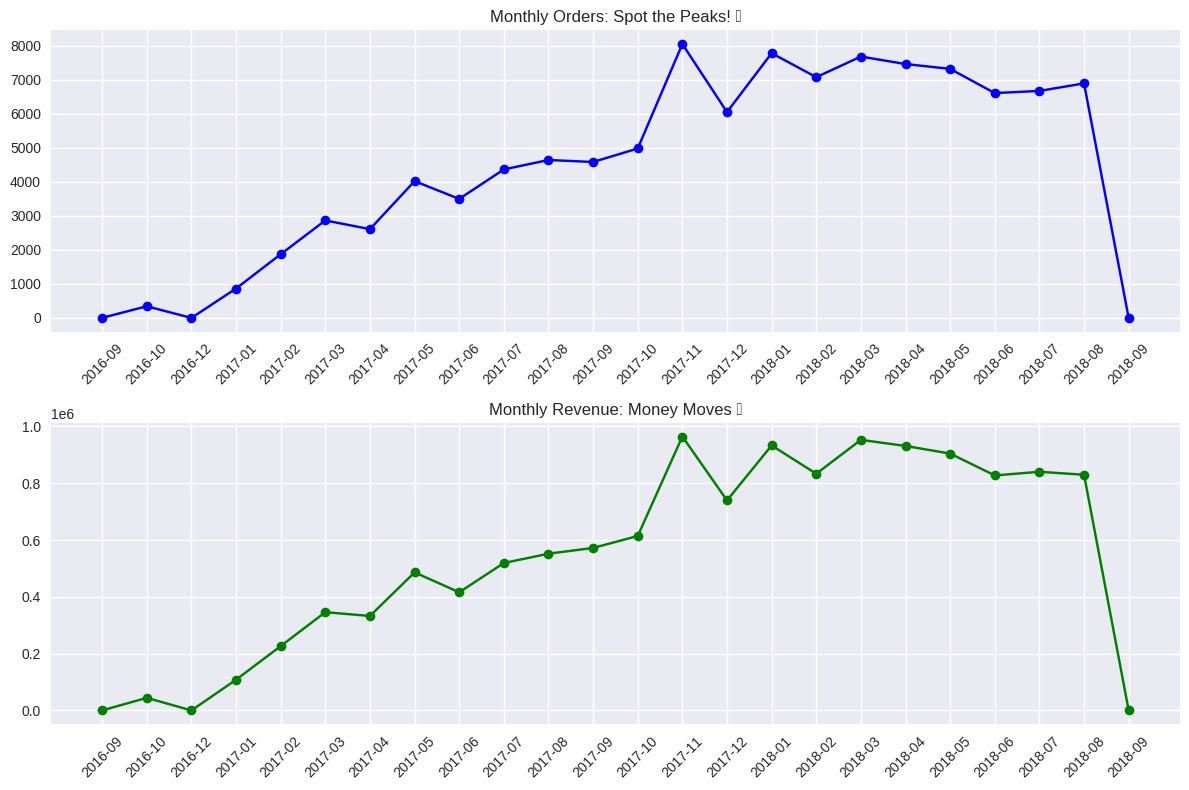

In [18]:
# Plot trends
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
ax[0].plot(monthly_orders['month'].astype(str), monthly_orders['orders'], marker='o', color='blue')
ax[0].set_title('Monthly Orders: Spot the Peaks! 📊')
ax[0].tick_params(axis='x', rotation=45)
ax[1].plot(monthly_revenue['month'].astype(str), monthly_revenue['revenue'], marker='o', color='green')
ax[1].set_title('Monthly Revenue: Money Moves 💰')
ax[1].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

- **Build a forecasting model to predict order volumes and total revenue for the next 6
months.**

---

In [19]:
# Forecast orders with ARIMA (p=1, d=1, q=1 – basic, tune if needed)
model = ARIMA(monthly_orders['orders'], order=(1,1,1))
model_fit = model.fit()
forecast = model_fit.forecast(steps=6)
forecast_dates = pd.period_range(start=monthly_orders['month'].iloc[-1] + 1, periods=6, freq='M')

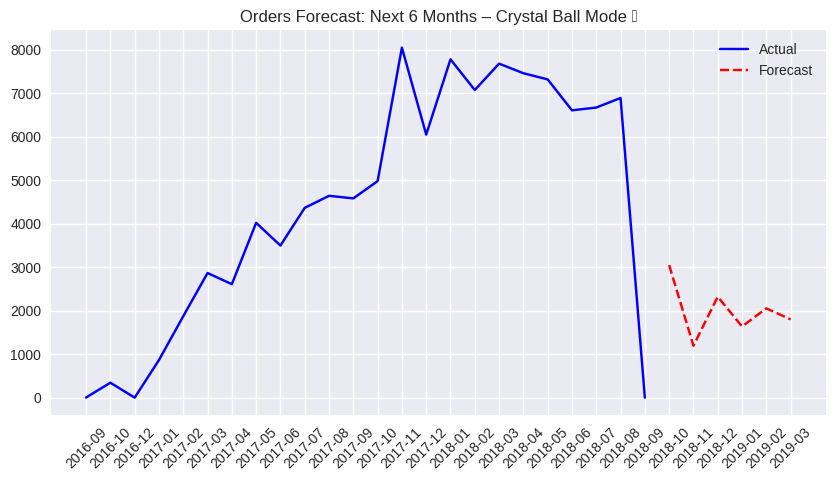

In [20]:
# Plot actual vs forecast
plt.figure(figsize=(10, 5))
plt.plot(monthly_orders['month'].astype(str), monthly_orders['orders'], label='Actual', color='blue')
plt.plot(forecast_dates.astype(str), forecast, label='Forecast', color='red', linestyle='--')
plt.title('Orders Forecast: Next 6 Months – Crystal Ball Mode 🔮')
plt.legend()
plt.xticks(rotation=45)
plt.show()

- **Provide insights on seasonality and growth trends for operational planning.**

---

- **Save actual vs. forecasted monthly order volumes as
data_outputs/forecast_results.csv.**

-----

In [21]:
# Save forecast results
forecast_df = pd.DataFrame({'month': forecast_dates.astype(str), 'forecasted_orders': forecast})
actual_recent = monthly_orders.tail(6)  # Last 6 for comparison
forecast_results = pd.concat([actual_recent.assign(type='actual'), forecast_df.assign(type='forecast')])
forecast_results.to_csv('data_outputs/forecast_results.csv', index=False)
print("Forecast results saved!")

Forecast results saved!


- **Save the top product-pair associations (support, confidence, lift) as
data_outputs/association_rules.csv.**

---

## <font color=skyblue >4. Cross-Sell Recommendations – Market Basket Analysis

---

In [ ]:
# Prep basket data – one-hot encode categories per order
basket = sales.groupby(['order_id', 'product_id'])['product_id'].count().unstack().fillna(0)
basket = basket.applymap(lambda x: 1 if x > 0 else 0)

In [ ]:
print("Basket shape:", basket.shape)
print("Non-zero entries:", (basket > 0).sum().sum())
print("Top categories:", basket.sum().sort_values(ascending=False).head(10))

In [ ]:
# Apriori for frequent itemsets (min support 0.01)
frequent_itemsets = apriori(basket, min_support=0.001, use_colnames=True)
rules = association_rules(frequent_itemsets, metric='lift', min_threshold=0.0)

In [ ]:
# convert lift to float for nlargest
rules['lift'] = rules['lift'].astype(float)
top_rules = rules.nlargest(10, 'lift')[['antecedents', 'consequents', 'support', 'confidence', 'lift']]
print(top_rules)

In [ ]:
# Add these lines
print("Frequent itemsets shape:", frequent_itemsets.shape)
print("Itemsets with 2+ items:", frequent_itemsets[frequent_itemsets['itemsets'].apply(len) > 1].shape[0])
print("Sample itemsets:", frequent_itemsets.head())

In [ ]:
# Top rules by lift
top_rules = rules.nlargest(10, 'lift')[['antecedents', 'consequents', 'support', 'confidence', 'lift']]
print(top_rules)

In [ ]:
# Viz top associations
plt.figure(figsize=(10, 6))
sns.barplot(data=top_rules, x='lift', y=top_rules.index, palette='coolwarm')
plt.title('Top Product Associations: Lift Levels')
plt.xlabel('Lift')
plt.ylabel('Rules')
plt.show()

In [ ]:
# Save top rules
top_rules.to_csv('data_outputs/association_rules.csv', index=False)
print("Association rules saved! 📁")